<a href="https://colab.research.google.com/github/SharaVigneswaran/Data-Science-Machine-Learning-Project/blob/main/Google_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science & Machine Learning


---


*Google Group: Jeanne Salamin & Shara Vigneswaran*


Introduction Text

# Data Importation

In [ ]:
import pandas as pd

In [ ]:
# Training Data Dataframe
training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/training_data.csv"
df_training_data = pd.read_csv(training_data_url)
df_training_data

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2


In [ ]:
# Unlabelled Test Data Dataframe
unlabelled_test_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/unlabelled_test_data.csv"
df_unlabelled_test_data = pd.read_csv(unlabelled_test_data_url)
df_unlabelled_test_data

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...,...
1195,1195,C'est un phénomène qui trouve une accélération...
1196,1196,Je vais parler au serveur et voir si on peut d...
1197,1197,Il n'était pas comme tant de gens qui par pare...
1198,1198,Ils deviennent dangereux pour notre économie.


## Data Augmentation

The goal of this data augmentation is to enhance a dataset used for natural language processing (NLP) tasks by increasing its diversity. It achieves this by replacing words in each sentence with their synonyms, thereby generating variations of the original sentences. By doing so, the augmented dataset becomes more varied, capturing a broader range of language patterns and nuances.

In [ ]:
import nltk
from nltk.corpus import wordnet
import random

# Ensure you have downloaded the necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_synonyms(word):
    """Return a set of synonyms for the word."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)  # Remove the original word to avoid redundancy
    return list(synonyms)

def synonym_replacement(sentence, n):
    """Replace up to n words in the sentence with their synonyms."""
    words = sentence.split()
    random.shuffle(words)
    new_words = words.copy()
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words[new_words.index(word)] = synonym
            n -= 1
            if n == 0:
                break
    return ' '.join(new_words)

def augment_dataset(dataframe, n=1):
    """Augment the dataset by replacing up to n words with synonyms in each sentence."""
    augmented_sentences = []
    for _, row in dataframe.iterrows():
        new_sentence = synonym_replacement(row['sentence'], n)
        augmented_sentences.append({'sentence': new_sentence, 'difficulty': row['difficulty']})
    return pd.DataFrame(augmented_sentences)


# Augment the dataset
augmented_df = augment_dataset(df_training_data, n=1)  # Change n to control the number of replacements per sentence
augmented_df = pd.concat([df_training_data, augmented_df]).reset_index(drop=True)
augmented_df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,id,sentence,difficulty
0,0.0,Les coûts kilométriques réels peuvent diverger...,C1
1,1.0,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2.0,Le test de niveau en français est sur le site ...,A1
3,3.0,Est-ce que ton mari est aussi de Boston?,A1
4,4.0,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
9595,NaN,superbe cet remplacer Sublime Porte en ce C'es...,B2
9596,NaN,First State pâleurs aux du ces majesté la chos...,C1
9597,NaN,lupus erythematosus des chaque Et premier renc...,A2
9598,NaN,Pa n'étant mémoire journalisation à sécurité o...,C2


## Expanding columns


Expanding the dependent variable (X) by appending additional columns to the existing training data during model training.

In [ ]:
import re

# Define a simple function to estimate syllable count based on vowel groups
def simple_syllable_count(text):
    count = 0
    vowels = "aeiouy"
    words = text.lower().split()
    for word in words:
        word_count = 0
        if word[0] in vowels:
            word_count += 1
        for i in range(1, len(word)):
            if word[i] in vowels and word[i - 1] not in vowels:
                word_count += 1
        if word.endswith('e'):
            word_count -= 1
        if word_count == 0:
            word_count += 1
        count += word_count
    return count

# Define function to calculate Type-Token Ratio
def type_token_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    else:
        return len(set(words)) / len(words)

# Recalculate the syllable count using the simple syllable estimation method
df_training_data['sentence_length'] = df_training_data['sentence'].apply(lambda x: len(x.split()))
df_training_data['type_token_ratio'] = df_training_data['sentence'].apply(type_token_ratio)
df_training_data['syllable_count'] = df_training_data['sentence'].apply(simple_syllable_count)
df_training_data['average_word_length'] = df_training_data['sentence'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)
df_training_data

,id,sentence,difficulty,sentence_length,type_token_ratio,syllable_count,average_word_length
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,0.763158,69,5.736842
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1.000000,13,4.250000
2,2,Le test de niveau en français est sur le site ...,A1,13,0.923077,18,4.153846
3,3,Est-ce que ton mari est aussi de Boston?,A1,8,1.000000,11,4.125000
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,34,0.823529,53,5.176471
...,...,...,...,...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2,26,1.000000,46,5.384615
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1,21,0.952381,31,4.666667
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2,14,0.928571,22,4.785714
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2,32,0.875000,56,6.093750


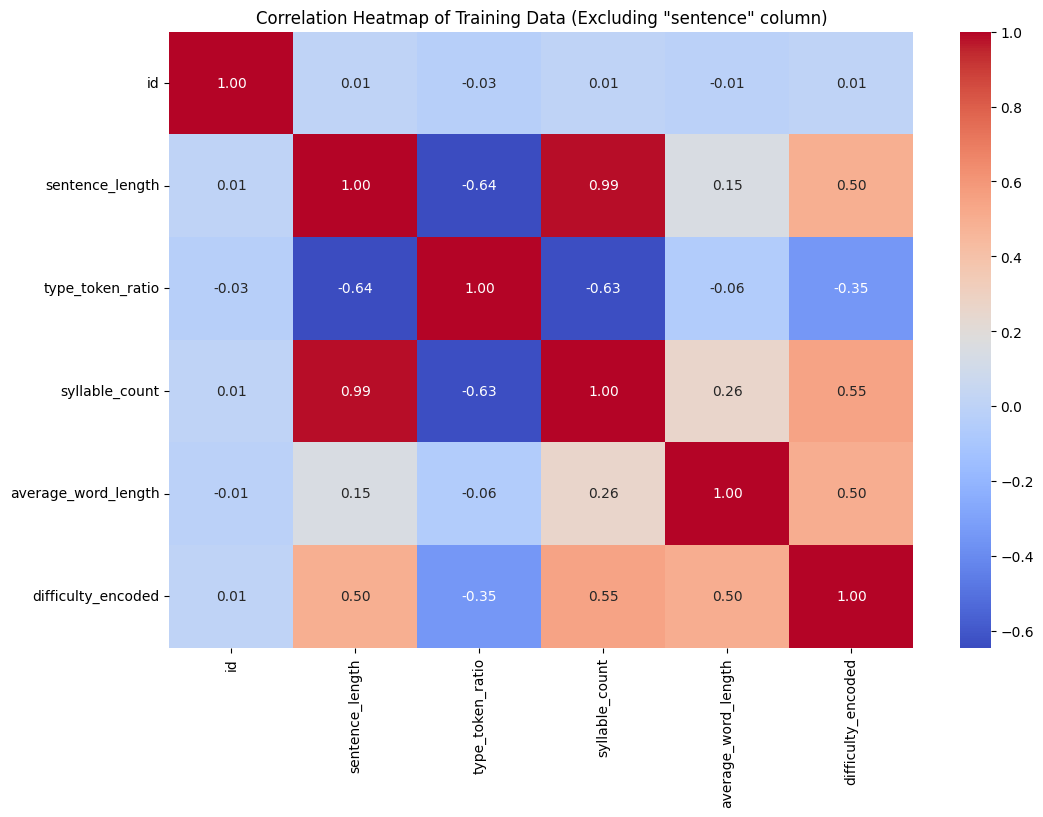

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding difficulty values
difficulty_encoding = {
    'A1': 1,
    'A2': 2,
    'B1': 3,
    'B2': 4,
    'C1': 5,
    'C2': 6
}

# Map difficulty values to numerical encoding
df_training_data['difficulty_encoded'] = df_training_data['difficulty'].map(difficulty_encoding)

# Drop the column named "sentence" before computing the correlation matrix
correlation_matrix = df_training_data.drop(columns=['sentence', 'difficulty']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Training Data (Excluding "sentence" column)')
plt.show()


## Data Size Augmentation

In [ ]:
# Augmented Size Training Data
new_training_data_url = "https://github.com/SharaVigneswaran/Data-Science-Machine-Learning-Project/raw/main/augmented_training_data_50.csv"
new_df_training_data = pd.read_csv(new_training_data_url)
new_df_training_data

,id,sentence,difficulty
0,0.0,Les coûts kilométriques réels peuvent diverger...,C1
1,1.0,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2.0,Le test de niveau en français est sur le site ...,A1
3,3.0,Est-ce que ton mari est aussi de Boston?,A1
4,4.0,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
5095,NaN,Elle avait l'habitude de faire du bénévolat à ...,B1
5096,NaN,"Après avoir écouté la chanson, elle la chantai...",B1
5097,NaN,"En voyageant en voiture, ils s'arrêtaient touj...",B1
5098,NaN,Elle avait l'habitude de cuisiner des plats tr...,B1


# Logistic Regression

In [ ]:
# Import packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the sentences using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df_training_data['sentence']).toarray()
y = df_training_data['difficulty']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=52)

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression(random_state=52, max_iter=10000)

# Train the Logistic Regression classifier
logistic_regression_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_lr = logistic_regression_classifier.predict(X_val)

# Calculate accuracy score
accuracy_lr = accuracy_score(y_val, y_pred_lr)
print(f"Accuracy of Logistic Regression classifier: {accuracy_lr}")

# Vectorize the sentences in the unlabelled test data using the same vectorizer
X_unlabelled = vectorizer.transform(df_unlabelled_test_data['sentence']).toarray()

# Make predictions on the unlabelled test data
y_pred_unlabelled_lr = logistic_regression_classifier.predict(X_unlabelled)

# Prepare the submission file
df_submission_lr = pd.DataFrame({
    'id': df_unlabelled_test_data['id'],
    'difficulty': y_pred_unlabelled_lr
})

Accuracy of Logistic Regression classifier: 0.46041666666666664


In [ ]:
# Calculate precision, recall, and F1-score
precision_lr = precision_score(y_val, y_pred_lr, average='weighted')  # 'weighted' accounts for label imbalance
recall_lr = recall_score(y_val, y_pred_lr, average='weighted')
f1_score_lr = f1_score(y_val, y_pred_lr, average='weighted')

# Printing all metrics
print(f"Accuracy of Logistic Regression classifier: {accuracy_lr}")
print(f"Precision of Logistic Regression classifier: {precision_lr}")
print(f"Recall of Logistic Regression classifier: {recall_lr}")
print(f"F1 Score of Logistic Regression classifier: {f1_score_lr}")

# For a detailed classification report
report_lr = classification_report(y_val, y_pred_lr)
print("Classification Report for Logistic Regression:\n", report_lr)

#KNN

In [ ]:
# Import packages
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
# Vectorize the sentences
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_training_data['sentence']).toarray()
y = df_training_data['difficulty']

# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the kNN classifier
knn_classifier = KNeighborsClassifier()

# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 16))}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)

# Perform grid search to find the best value of n_neighbors
grid_search.fit(X_train, y_train)

# Get the best value of n_neighbors
best_k = grid_search.best_params_['n_neighbors']
print(f"Best value of n_neighbors: {best_k}")

# Train the kNN classifier with the best value of n_neighbors
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Evaluate the performance of the best kNN classifier
y_pred_knn_best = knn_best.predict(X_val)
accuracy_knn_best = accuracy_score(y_val, y_pred_knn_best)
print(f"Accuracy of best kNN classifier: {accuracy_knn_best}")

# Load the unlabelled test data
df_unlabelled_test_data = pd.read_csv(unlabelled_test_data_url)

# Vectorize the sentences in the unlabelled test data
X_unlabelled = vectorizer.transform(df_unlabelled_test_data['sentence']).toarray()

# Make predictions on the unlabelled test data
y_pred_unlabelled = knn_best.predict(X_unlabelled)

# Prepare the submission file
df_submission = pd.DataFrame({
    'id': df_unlabelled_test_data['id'],
    'difficulty': y_pred_unlabelled
})

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best value of n_neighbors: 15
Accuracy of best kNN classifier: 0.34791666666666665


In [ ]:
# Calculate precision, recall, and F1-score
precision_knn = precision_score(y_val, y_pred_knn_best, average='weighted')
recall_knn = recall_score(y_val, y_pred_knn_best, average='weighted')
f1_score_knn = f1_score(y_val, y_pred_knn_best, average='weighted')

# Print calculated metrics
print(f"Precision of KNN classifier: {precision_knn}")
print(f"Recall of KNN classifier: {recall_knn}")
print(f"F1 Score of KNN classifier: {f1_score_knn}")

# Detailed classification report for in-depth analysis
classification_report_knn = classification_report(y_val, y_pred_knn_best)
print("Classification Report for KNN:\n", classification_report_knn)

Precision of KNN classifier: 0.3849923172962857
Recall of KNN classifier: 0.34791666666666665
F1 Score of KNN classifier: 0.31914136850705555
Classification Report for KNN:
               precision    recall  f1-score   support

          A1       0.41      0.64      0.50       166
          A2       0.26      0.16      0.20       158
          B1       0.35      0.12      0.18       166
          B2       0.42      0.28      0.34       153
          C1       0.27      0.68      0.39       152
          C2       0.59      0.21      0.31       165

    accuracy                           0.35       960
   macro avg       0.38      0.35      0.32       960
weighted avg       0.38      0.35      0.32       960



# Decision Trees

In [ ]:
# Import packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
# Vectorize the sentences
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_training_data['sentence']).toarray()
y = df_training_data['difficulty']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)

# Train the Decision Tree classifier on the training data
decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_dt = decision_tree_classifier.predict(X_val)

# Calculate accuracy score on the validation data
accuracy_dt = accuracy_score(y_val, y_pred_dt)
print(f"Accuracy of Decision Tree classifier on validation data: {accuracy_dt}")

# Vectorize the sentences in the unlabelled test data using the same vectorizer as before
X_unlabelled = vectorizer.transform(df_unlabelled_test_data['sentence']).toarray()

# Make predictions on the unlabelled test data
y_pred_unlabelled_dt = decision_tree_classifier.predict(X_unlabelled)

# Prepare the submission file
df_submission_dt = pd.DataFrame({
    'id': df_unlabelled_test_data['id'],
    'difficulty': y_pred_unlabelled_dt
})

In [ ]:
# Calculate precision, recall, and F1-score
precision_dt = precision_score(y_val, y_pred_dt, average='weighted')
recall_dt = recall_score(y_val, y_pred_dt, average='weighted')
f1_score_dt = f1_score(y_val, y_pred_dt, average='weighted')

# Printing all metrics
print(f"Precision of Decision Tree classifier: {precision_dt}")
print(f"Recall of Decision Tree classifier: {recall_dt}")
print(f"F1 Score of Decision Tree classifier: {f1_score_dt}")

# For a detailed classification report
report_dt = classification_report(y_val, y_pred_dt)
print("Classification Report for Decision Tree:\n", report_dt)

# Random Forest

In [ ]:
# Import Packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Vectorize the sentences using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_training_data['sentence']).toarray()
y = df_training_data['difficulty']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest classifier on the training data
random_forest_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = random_forest_classifier.predict(X_val)

# Calculate accuracy score
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy of Random Forest classifier: {accuracy_rf}")

# Vectorize the sentences in the unlabelled test data using the same vectorizer
X_unlabelled = vectorizer.transform(df_unlabelled_test_data['sentence']).toarray()

# Make predictions on the unlabelled test data
y_pred_unlabelled_rf = random_forest_classifier.predict(X_unlabelled)

# Prepare the submission file
df_submission_rf = pd.DataFrame({
    'id': df_unlabelled_test_data['id'],
    'difficulty': y_pred_unlabelled_rf
})

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision, recall, and F1-score
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')
f1_score_rf = f1_score(y_val, y_pred_rf, average='weighted')

# Printing all metrics
print(f"Precision of Random Forest classifier: {precision_rf}")
print(f"Recall of Random Forest classifier: {recall_rf}")
print(f"F1 Score of Random Forest classifier: {f1_score_rf}")

# For a detailed classification report
report_rf = classification_report(y_val, y_pred_rf)
print("Classification Report for Random Forest:\n", report_rf)

# Neural Network

In [ ]:
# Import Packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Vectorize the sentences using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_training_data['sentence']).toarray()

# Encode the difficulty levels to one-hot categorical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_training_data['difficulty'])
y_categorical = to_categorical(y_encoded)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Define the neural network architecture
model = Sequential()
model.add(Dense(512, input_shape=(1000,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the performance of the neural network
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Accuracy: {val_accuracy}')

# Vectorize the sentences in the unlabelled test data using the same vectorizer
X_unlabelled = vectorizer.transform(df_unlabelled_test_data['sentence']).toarray()

# Make predictions on the unlabelled test data
y_pred_nn_proba = model.predict(X_unlabelled)
y_pred_nn = label_encoder.inverse_transform(y_pred_nn_proba.argmax(axis=1))

# Prepare the submission file
df_submission_nn = pd.DataFrame({
    'id': df_unlabelled_test_data['id'],
    'difficulty': y_pred_nn
})

In [ ]:
# Convert predictions from one-hot encoded back to class integers for validation data
y_val_pred = model.predict(X_val)
y_val_pred_class = np.argmax(y_val_pred, axis=1)
y_val_true_class = np.argmax(y_val, axis=1)

# Calculate precision, recall, and F1-score
precision_nn = precision_score(y_val_true_class, y_val_pred_class, average='weighted')
recall_nn = recall_score(y_val_true_class, y_val_pred_class, average='weighted')
f1_score_nn = f1_score(y_val_true_class, y_val_pred_class, average='weighted')

# Printing all metrics
print(f"Precision of Neural Network classifier: {precision_nn}")
print(f"Recall of Neural Network classifier: {recall_nn}")
print(f"F1 Score of Neural Network classifier: {f1_score_nn}")

# For a detailed classification report
report_nn = classification_report(y_val_true_class, y_val_pred_class)
print("Classification Report for Neural Network:\n", report_nn)


#Neural Network (CNN)

In [ ]:
# Import packages
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import classification_report

In [ ]:
# Load data
df_training_data = pd.read_csv(training_data_url)
df_unlabelled_test_data = pd.read_csv(unlabelled_test_data_url)

# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_training_data['sentence'])
vocab_size = len(tokenizer.word_index) + 1

# Convert texts to sequences
X = tokenizer.texts_to_sequences(df_training_data['sentence'])
X_test = tokenizer.texts_to_sequences(df_unlabelled_test_data['sentence'])

# Determine max length of sequences in training data
max_length = max(len(x) for x in X)
X_padded = pad_sequences(X, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post')

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_training_data['difficulty'])
y_categorical = to_categorical(y)  # One-hot encode labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy}')

In [ ]:
# Predict probabilities for validation set
y_val_pred_prob = model.predict(X_val)

# Convert probabilities to labels
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# Convert one-hot encoded labels back to single label
y_val_labels = np.argmax(y_val, axis=1)

# Generate classification report
report = classification_report(y_val_labels, y_val_pred, target_names=label_encoder.classes_)
print(report)

# XG Boost

In [ ]:
# Import Packages
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Load data
df_training_data = pd.read_csv(training_data_url)
df_unlabelled_test_data = pd.read_csv(unlabelled_test_data_url)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features

# Vectorize the text
X_tfidf = tfidf_vectorizer.fit_transform(df_training_data['sentence']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(df_unlabelled_test_data['sentence']).toarray()

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_training_data['difficulty'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_),
                              learning_rate=0.1, n_estimators=100, max_depth=6, seed=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate the model
train_accuracy = xgb_model.score(X_train, y_train)
val_accuracy = xgb_model.score(X_val, y_val)
print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

In [ ]:
# Predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

# Calculate precision, recall, F1-score, and accuracy
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')
accuracy_train = accuracy_score(y_train, y_train_pred)

precision_val = precision_score(y_val, y_val_pred, average='weighted')
recall_val = recall_score(y_val, y_val_pred, average='weighted')
f1_val = f1_score(y_val, y_val_pred, average='weighted')
accuracy_val = accuracy_score(y_val, y_val_pred)

# Print statistics
print("Train Set:")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")
print(f"Accuracy: {accuracy_train:.4f}")

print("\nValidation Set:")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-score: {f1_val:.4f}")
print(f"Accuracy: {accuracy_val:.4f}")